# Import Module

In [4]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
#from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [5]:
variables = ['pr']
variable = 'pr'
TITLE = 'Precipitation'
ylabel = '$E_{pr}$ ($mm/day$)'

### Paths

In [6]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [7]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [8]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [9]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Get data : obs, PPE, p1

In [13]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename_obs = 'pr_mon_mean_197901-198112_regrid.nc'

In [14]:
path = path_observation
variables = [variable]
df_obs = load_monthly_clim(path, filename_obs, variables)
df_obs

pr
month lat        lon                
1     -88.927735 0.00000    0.016181
                 1.40625    0.017889
                 2.81250    0.018091
                 4.21875    0.019936
                 5.62500    0.020032
...                              ...
12     88.927735 352.96875  0.485702
                 354.37500  0.466599
                 355.78125  0.466735
                 357.18750  0.467983
                 358.59375  0.467797

[393216 rows x 1 columns]

In [15]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.38347158 0.37245688 ... 0.503336 0.5036048

In [16]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_pr_xarr(path, filename, variables)

In [17]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    i=i+1

In [18]:
amip['p1'] = p1_amip

In [19]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [20]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [21]:
## --Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [22]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [23]:
anom_w = (anom*W_eof_3D)
anom_w

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

# Bootstrap

In [24]:
def MultiLinReg(X_train, pc_train, EOF_nb, x_pred, variable) :
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")    

    y_train = pc_train[:,EOF_nb-1]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(x_pred)
    
    return y_pred

In [25]:
def emulator_eval_EOF_modes(X_train, X_test, y_train, y_test) : 

    # Create an EOF solver to do the EOF analysis. 
    solver = Eof(y_train, center=False, weights=None)
    pc_train = solver.pcs(npcs=102, pcscaling=1)

    # Prediction and skill evaluation : loop over the 91 modes
    pc_test = solver.projectField(y_test, neofs=102, weighted=False, eofscaling=1)
    x_pred_IS = X_train
    x_pred_OS = X_test
    r_corr_list_IS = []
    r_corr_list_OS = []
    for EOF_nb in range(1,len(pc_train), 1) :
        y_pred_OS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_OS, variable)
        pc_test_tmp = pc_test[:,EOF_nb-1]
        df_OS = pd.DataFrame(y_pred_OS, columns=['pred'])
        df_OS['true'] = pc_test_tmp
        r_corr_OS = np.corrcoef(df_OS['pred'], df_OS['true'])
        r_corr_list_OS.append(r_corr_OS[0,1])
    
        y_pred_IS = MultiLinReg(X_train, pc_train, EOF_nb, x_pred_IS, variable)
        df_IS = pd.DataFrame(y_pred_IS, columns=['pred'])
        pc_train_tmp = pc_train[:,EOF_nb-1]
        df_IS['true'] = pc_train_tmp
        r_corr_IS = np.corrcoef(df_IS['pred'], df_IS['true'])
        r_corr_list_IS.append(r_corr_IS[0,1])
    
    return r_corr_list_OS, r_corr_list_IS

In [26]:
from sklearn.model_selection import train_test_split
EOF_nb = 1
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = anom_w[1:]

df_fig = pd.DataFrame(range(1, 91, 1), columns=['mode'])
for cpt in range(1,11,1) :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    r_corr_list_OS, r_corr_list_IS = emulator_eval_EOF_modes(X_train, X_test, y_train, y_test)
    df_fig['r_OS_'+str(cpt)] = r_corr_list_OS
    df_fig['r_IS_'+str(cpt)] = r_corr_list_IS

df_fig

,mode,r_OS_1,r_IS_1,r_OS_2,r_IS_2,r_OS_3,r_IS_3,r_OS_4,r_IS_4,r_OS_5,...,r_OS_6,r_IS_6,r_OS_7,r_IS_7,r_OS_8,r_IS_8,r_OS_9,r_IS_9,r_OS_10,r_IS_10
0,1,0.857389,0.942169,0.761554,0.948131,0.826666,0.942185,0.766054,0.949515,0.833677,...,0.901765,0.936750,0.894775,0.936667,0.927260,0.934302,0.898106,0.938409,0.922809,0.937708
1,2,0.651170,0.923864,0.886592,0.901369,0.556018,0.926503,0.324195,0.924783,0.814566,...,0.716193,0.908669,0.874171,0.899377,0.876715,0.896607,0.859863,0.905537,0.769648,0.906078
2,3,-0.056834,0.837785,0.496434,0.793509,0.690095,0.776643,0.277863,0.789865,0.529137,...,0.531842,0.780368,0.612376,0.791033,0.299165,0.825926,-0.372234,0.842263,0.264899,0.814837
3,4,0.812283,0.629272,-0.535919,0.745282,0.461126,0.700715,0.489701,0.744856,0.497566,...,0.471057,0.753904,0.478582,0.708995,0.138212,0.760255,0.241516,0.692521,0.562367,0.714357
4,5,0.818627,0.903011,0.725384,0.871551,0.812151,0.891818,0.722112,0.885022,0.266259,...,0.697667,0.865353,0.798227,0.900355,0.945009,0.882149,0.797288,0.898735,0.902868,0.884042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86,0.665363,0.536876,-0.042700,0.463665,0.071670,0.545506,-0.014348,0.411953,0.481630,...,0.488232,0.484007,-0.197820,0.500318,0.037131,0.536204,-0.287908,0.362807,-0.261618,0.425124
86,87,-0.092909,0.452718,0.095132,0.462729,-0.374626,0.530227,0.062647,0.456232,-0.462849,...,-0.502851,0.501673,-0.008524,0.560379,0.247956,0.537715,-0.298807,0.472728,-0.468185,0.529241
87,88,0.210908,0.425379,-0.162375,0.454884,-0.069048,0.472663,-0.478459,0.441140,-0.098214,...,0.164819,0.513609,0.459575,0.531030,0.196250,0.619046,-0.040220,0.562841,-0.173694,0.541706
88,89,0.199046,0.568115,0.435592,0.473574,0.301317,0.536163,-0.524634,0.483768,0.234394,...,0.046903,0.498534,-0.342596,0.501456,-0.029519,0.462791,-0.120874,0.518865,0.025160,0.427021


In [27]:
df_OS = pd.DataFrame(df_fig['r_OS_1'], columns=['r1'])
df_IS = pd.DataFrame(df_fig['r_IS_1'], columns=['r1'])

for j in range(2,11,1) :
    df_OS['r'+str(j)] = df_fig['r_OS_'+str(j)]
    df_IS['r'+str(j)] = df_fig['r_IS_'+str(j)]

r_OS_mean = df_OS.mean(axis = 1)
r_OS_std = df_OS.std(axis = 1)
df_fig['r_OS_mean'] = r_OS_mean
df_fig['r_OS_std'] = r_OS_std

r_IS_mean = df_IS.mean(axis = 1)
r_IS_std = df_IS.std(axis = 1)
df_fig['r_IS_mean'] = r_IS_mean
df_fig['r_IS_std'] = r_IS_std

df_fig['mode'] = range(0, 90, 1)
df_fig

,mode,r_OS_1,r_IS_1,r_OS_2,r_IS_2,r_OS_3,r_IS_3,r_OS_4,r_IS_4,r_OS_5,...,r_OS_8,r_IS_8,r_OS_9,r_IS_9,r_OS_10,r_IS_10,r_OS_mean,r_OS_std,r_IS_mean,r_IS_std
0,0,0.857389,0.942169,0.761554,0.948131,0.826666,0.942185,0.766054,0.949515,0.833677,...,0.927260,0.934302,0.898106,0.938409,0.922809,0.937708,0.859185,0.064411,0.940778,0.005350
1,1,0.651170,0.923864,0.886592,0.901369,0.556018,0.926503,0.324195,0.924783,0.814566,...,0.876715,0.896607,0.859863,0.905537,0.769648,0.906078,0.741996,0.189164,0.908361,0.010512
2,2,-0.056834,0.837785,0.496434,0.793509,0.690095,0.776643,0.277863,0.789865,0.529137,...,0.299165,0.825926,-0.372234,0.842263,0.264899,0.814837,0.369953,0.317052,0.798113,0.024471
3,3,0.812283,0.629272,-0.535919,0.745282,0.461126,0.700715,0.489701,0.744856,0.497566,...,0.138212,0.760255,0.241516,0.692521,0.562367,0.714357,0.311579,0.346070,0.736350,0.035955
4,4,0.818627,0.903011,0.725384,0.871551,0.812151,0.891818,0.722112,0.885022,0.266259,...,0.945009,0.882149,0.797288,0.898735,0.902868,0.884042,0.740774,0.195954,0.881114,0.016072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,0.665363,0.536876,-0.042700,0.463665,0.071670,0.545506,-0.014348,0.411953,0.481630,...,0.037131,0.536204,-0.287908,0.362807,-0.261618,0.425124,0.030474,0.287444,0.467120,0.059223
86,86,-0.092909,0.452718,0.095132,0.462729,-0.374626,0.530227,0.062647,0.456232,-0.462849,...,0.247956,0.537715,-0.298807,0.472728,-0.468185,0.529241,-0.190012,0.288423,0.513975,0.042914
87,87,0.210908,0.425379,-0.162375,0.454884,-0.069048,0.472663,-0.478459,0.441140,-0.098214,...,0.196250,0.619046,-0.040220,0.562841,-0.173694,0.541706,-0.022374,0.267832,0.497812,0.080421
88,88,0.199046,0.568115,0.435592,0.473574,0.301317,0.536163,-0.524634,0.483768,0.234394,...,-0.029519,0.462791,-0.120874,0.518865,0.025160,0.427021,0.002860,0.305436,0.492545,0.034972


In [28]:
cumul_corr_mean = []
cumul_corr_std = []
for i in range(0, len(df_fig), 1) :
    tmp = df_fig[0:i]['r_OS_mean'].mean()
    cumul_corr_mean.append(tmp)
    
    tmp = df_fig[0:i]['r_OS_std'].mean()
    cumul_corr_std.append(tmp)
    
df_fig['cumul_corr_mean'] = cumul_corr_mean
df_fig['cumul_corr_std'] = cumul_corr_std

In [29]:
## Test moyenne de corrélation pour 5, 10, 15, 20, 25, 50, 75 
mean_OS_5 = df_fig[0:5]['r_OS_mean'].mean()
mean_OS_10 = df_fig[0:10]['r_OS_mean'].mean()
mean_OS_15 = df_fig[0:15]['r_OS_mean'].mean()
mean_OS_20 = df_fig[0:20]['r_OS_mean'].mean()
mean_OS_25 = df_fig[0:25]['r_OS_mean'].mean()
mean_OS_50 = df_fig[0:50]['r_OS_mean'].mean()

# Figure

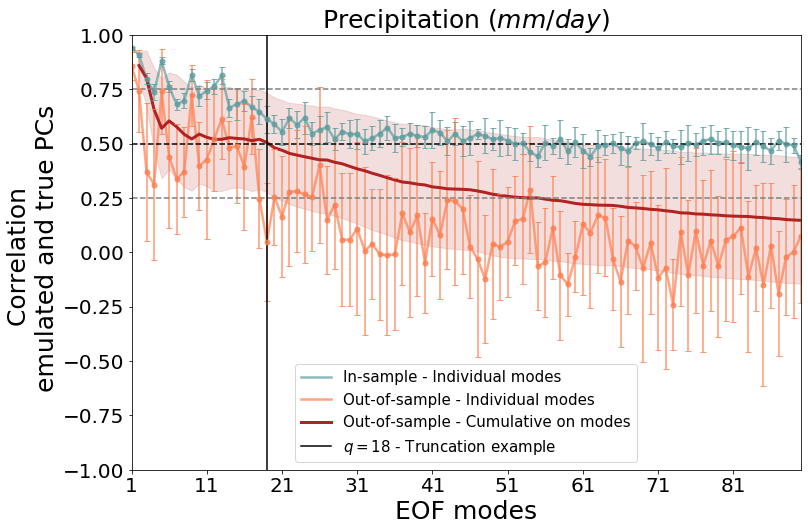

In [30]:
plt.figure(figsize=(12, 8))
    

ax = plt.gca()

df_fig.plot(kind='line', y='r_IS_mean', color = 'cadetblue', alpha=0.7, linewidth=2.5, ax=ax)
df_fig.plot(kind='line', y='r_OS_mean', color = 'coral', alpha=0.7, linewidth=2.5, ax=ax)

df_fig.plot(kind='line', y='cumul_corr_mean', color = 'firebrick', alpha=1, linewidth=3, ax=ax)
xfit = df_fig['mode']
yfit = df_fig['cumul_corr_mean']
dyfit = df_fig['cumul_corr_std']
plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='firebrick', alpha=0.15)

plt.errorbar(x=df_fig['mode'], y=df_fig['r_IS_mean'], yerr=df_fig['r_IS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='cadetblue', 
             color= 'cadetblue')

plt.errorbar(x=df_fig['mode'], y=df_fig['r_OS_mean'], yerr=df_fig['r_OS_std'], xerr=None, 
             linestyle='none', 
             marker='.', markersize=10,
             capsize=3,
             alpha=0.8,
             ecolor='coral', 
             color= 'coral')

plt.axhline(y=0.5, color='black', linestyle='dashed', label = '_nolegend_')
plt.axhline(y=0.25, color='gray', linestyle='dashed', label = '_nolegend_')
plt.axhline(y=0.75, color='gray', linestyle='dashed', label = '_nolegend_')

plt.axvline(x=18, color='black', linestyle='solid')

#ax.axhline(0, color='k', alpha=0.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('EOF modes', size = 25)
ax.set_ylabel('Correlation \n emulated and true PCs', size = 25)
ax.set_title('Precipitation ($mm/day$)', fontsize=25)
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xticks(range(0, 90, 10))
ax.set_xticklabels(range(1, 91, 10))

plt.xticks(rotation=0)

# Legend .................

legend = [ 'In-sample - Individual modes', 'Out-of-sample - Individual modes', 
          'Out-of-sample - Cumulative on modes', '$q=18$ - Truncation example']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Skill_emul_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()